Calculating the Hausdorff distances...
	diameter = 1.0E+00, distance = 3.72E+00
	diameter = 1.0E-01, distance = 2.55E-02
	diameter = 1.0E-02, distance = 3.84E-03
	diameter = 1.0E-03, distance = 7.93E-04
Done!


Slope:1.1836823046165792 intercept:0.1404062829300763


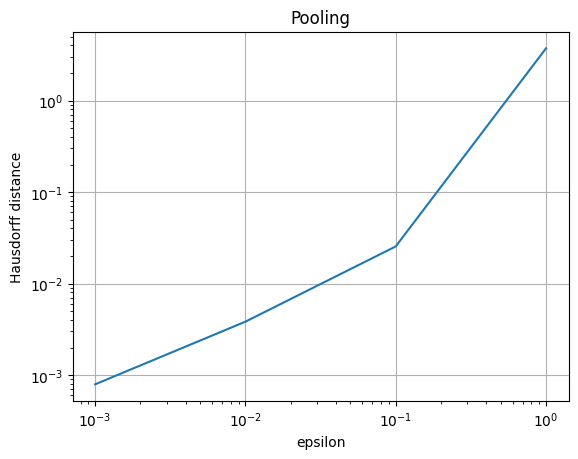

Pooling executed


In [1]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from pyomo.opt import SolverFactory, TerminationCondition
from src.analyses.value_function import ValueFunction
from src.analyses.convergence_analysis import HausdorffAnalyzer
import numpy as np
import matplotlib.pyplot as plt
from src.models.cz_model import CaoZavalaModel, CaoZavalaAlgo
from src.models.lagrangean_model import LagrangeanModel, LagrangeanAlgo
from scipy.optimize import curve_fit
def get_critical_width(alg,y_optimal,k=1,abs_epsilon=0.01):
    haus=HausdorffAnalyzer(alg)
    print(f"width: {abs_epsilon/k}")
    print(haus._gen_interval(y_optimal,abs_epsilon/k))
def linear_func(x, a, b):
        return a * x + b
def convergence_analysis(alg,fixed_pt,optimal_sol,start=-5,stop=0,steps=6,name="instance"):

    haus=HausdorffAnalyzer(alg)
    eps_list, distances=haus.analyze(y=fixed_pt, v=optimal_sol,
                    eps_min= start, eps_max = stop, steps= steps,
                    y_optimal= True)
    log_eps = np.log10(eps_list)
    log_distances = np.log10(distances)

    # Perform curve fitting
    params, _ = curve_fit(linear_func, log_eps, log_distances)
    print(f"Slope:{params[0]} intercept:{params[1]}")
    plt.loglog(eps_list, distances)
    plt.grid()
    plt.xticks(np.logspace(start, stop, steps))
    plt.xlabel("epsilon")
    plt.ylabel("Hausdorff distance")
    plt.title(name)
    plt.show()
from NSPLIB.src.instances.pooling_contract_selection.pooling import const_model
# Constants
pooling_obj=-1338.2471283376406
pooling_sol = {
    'A[1]': 300.0, 'A[2]': 201.92127476313524, 'A[3]': 0.0, 'A[4]': 0.0, 'A[5]': 245.18105081826008,
    'S[1]': 247.10232558139526, 'S[2]': 0.0, 'S[3]': 0.0, 'S[4]': 500.0
}

pooling_y_bound = {
    'A[1]': [0, 300], 'A[2]': [0, 250], 'A[3]': [0, 0], 'A[4]': [0, 0], 'A[5]': [0, 300],
    'S[1]': [0, 400], 'S[2]': [0, 0], 'S[3]': [0, 0], 'S[4]': [0, 500]
}
sto_m = const_model()
m = LagrangeanModel.from_sto_m(sto_m)
m.build()
binary_ys = ['lambd[1]', 'lambd[2]', 'lambd[3]', 'lambd[4]', 'lambd[5]', 'theta[1]', 'theta[2]', 'theta[3]', 'theta[4]']
binary_y_val = {y: 0 for y in binary_ys}
binary_y_val['lambd[1]'] = 1
binary_y_val['lambd[2]'] = 1
binary_y_val['lambd[5]'] = 1
binary_y_val['theta[1]'] = 1
binary_y_val['theta[4]'] = 1
m.fix_binary_y(binary_y_val)

alg=LagrangeanAlgo(m,solver="baron",lag_iter=20)
convergence_analysis(alg,pooling_sol,pooling_obj,start=-3,stop=0,steps=4,name="Pooling")
print("Pooling executed")